## Objective

We will now look at what the finetuned ResNet50 model is learning.

In [2]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


## Standard Imports

In [0]:
#!pip install innvestigate

In [0]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

import sys
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator

# Run this if you are using google colab
sys.path.append('/content/drive/My Drive/')

from src.utils import *
from src.visualisation import *
from src.model import make_finetuned_resnet50

In [0]:
!unzip -q 'drive/My Drive/cell-images-for-detecting-malaria.zip'

# Create 'Combined' directory and copy all the png images over
# Note that the name 'Combined' must match that in the directory of the generator

!mkdir Combined 
!cp -a cell_images/cell_images/Parasitized/. Combined
!cp -a cell_images/cell_images/Uninfected/. Combined

## Reobtain the data and generators

In [0]:
# Read from the csv 
df_train = pd.read_csv('drive/My Drive/data/malaria_train_combined.csv')
df_val = pd.read_csv('drive/My Drive/data/malaria_val_combined.csv')
df_test = pd.read_csv('drive/My Drive/data/malaria_test_combined.csv')

df_train['labels'] = df_train['labels'].astype(str)
df_val['labels'] = df_val['labels'].astype(str)
df_test['labels'] = df_test['labels'].astype(str)

In [0]:
from keras.applications.resnet50 import preprocess_input

# Create generators manually
train_datagen = ImageDataGenerator(
     preprocessing_function=lambda x: preprocess_input(x),
     shear_range=0.2,
     zoom_range=0.2,
     #width_shift_range=0.2,
     #height_shift_range=0.2,
     horizontal_flip=True)
  
val_datagen = ImageDataGenerator(preprocessing_function=lambda x: preprocess_input(x))

In [11]:
# Get the generators
train_gen, valid_gen, test_gen = fit_into_generators(df_train,df_val,df_test,train_datagen, val_datagen,batch_size=32,shape=(224,224))

Found 19291 validated image filenames belonging to 2 classes.
Found 6199 validated image filenames belonging to 2 classes.
Found 2068 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 1 invalid image filename(s) in x_col="train_combined". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 1 invalid image filename(s) in x_col="val_combined". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [0]:
from keras import layers, optimizers

In [13]:
# Reload finetuned-resnet50 model
model = make_finetuned_resnet50()

model.load_weights('/content/drive/My Drive/weights/finetuned_resnet50_weights_for_predicting_malaria.h5')
model.compile(optimizers.Adam(0.01), loss = "categorical_crossentropy", metrics=['accuracy'])

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 2s 0us/step


In [14]:
model.evaluate_generator(test_gen)

[0.14404538587975088, 0.9492263054939949]

## Get Confusion Matrix

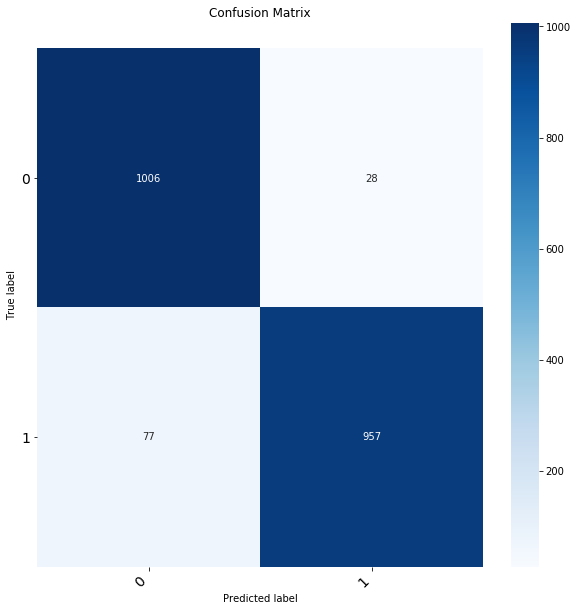

In [15]:
tp,tn,fp,fn = get_confusion_matrix(model,test_gen)

- 28 False Positives and 77 False negatives

## Visualisation of 'Explainability' of finetuned resnet50 model 

In [0]:
import imp
import innvestigate
import innvestigate.utils as iutils

imgnetutils = imp.load_source("utils_imagenet", "/content/drive/My Drive/src/utils_imagenet.py")

In [0]:
# Define methods
methods = [
    # NAME                    OPT.PARAMS                POSTPROC FXN                TITLE
    # Function
    ("gradient",              {"postprocess": "abs"},   imgnetutils.graymap,       "Gradient"),
    
    ("smoothgrad",            {"postprocess": "square"},imgnetutils.graymap,       "SmoothGrad"),

    ("lrp.sequential_preset_a_flat",{"epsilon": 1},     imgnetutils.heatmap,       "LRP-PresetAFlat")
]

In [0]:
from keras import Model

# This is to remove 'model' in the layer for innvestigate to work
x = model.layers[0].layers[-1].get_output_at(0)

for layer in model.layers[1:]:
  x = layer(x)
model_new = Model(inputs=model.layers[0].inputs, outputs=x)

In [0]:
# Create model without trailing softmax
model_wo_softmax = iutils.keras.graph.model_wo_softmax(model_new)

# Create analyzers.
analyzers = []
for method in methods:
  analyzer = innvestigate.create_analyzer(method[0],        # analysis method identifier
                                          model_wo_softmax, # model without softmax output
                                          **method[1])      # optional analysis parameters
  analyzers.append(analyzer)

In [0]:
analyzer_names = ['Gradient', 'Smooth Gradient', 'LRP Preset A Flat']

### True positive samples 

In [31]:
# 4 random true positive samples
sample_indices = [np.random.choice(len(tp[0])) for i in range(4)]
print('The sample indices for true positives are {}'.format(sample_indices))


The sample indices for true positives are [180, 739, 308, 462]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


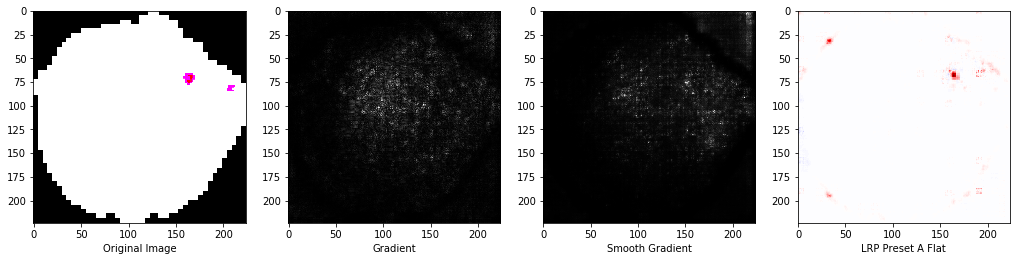

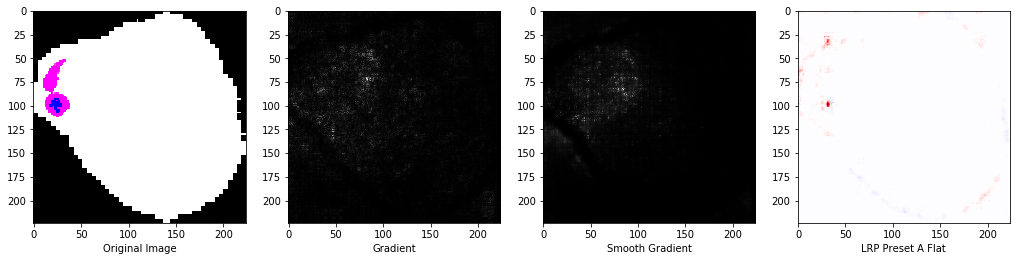

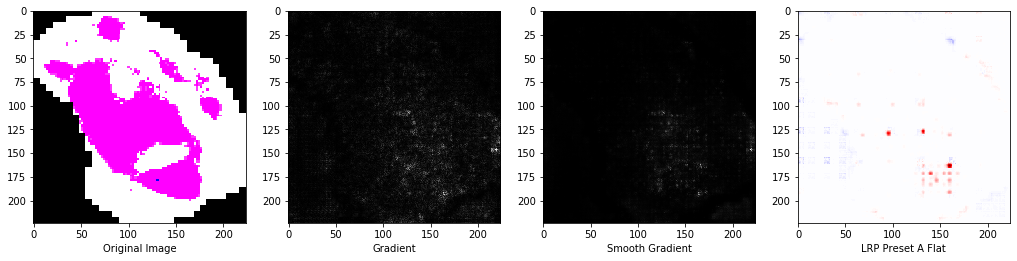

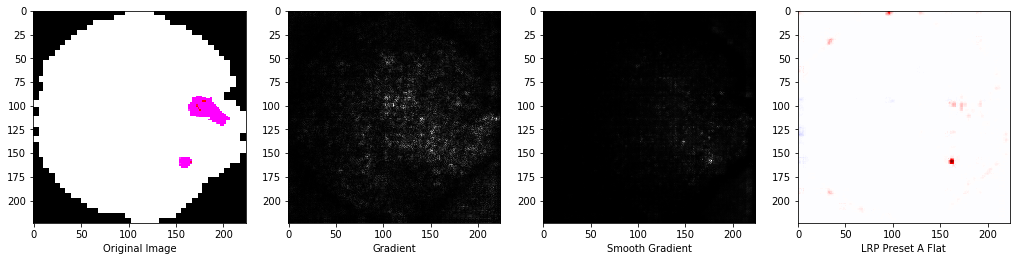

In [32]:
for image_index in sample_indices:
  show_explanation(tp[:,image_index,:,:,:],analyzers,analyzer_names,methods)

For all 4 true positive samples, the model has managed to point at the right parts for predicting 'Parasitized'. However, it seems that what it learns is slightly different from the baseline model. This is indicated by the fact that the feature attribute maps shows 'sharp dots' (bright white or red) instead of highlighting the whole 'parasitized' part. This could be partly because the model is looking at a preprocessed image this time round.

### True Negative Samples

In [33]:
# 4 random true negative samples
sample_indices = [np.random.choice(len(tn[0])) for i in range(4)]
print('The sample indices for true negatives are {}'.format(sample_indices))

The sample indices for true negatives are [193, 159, 633, 874]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


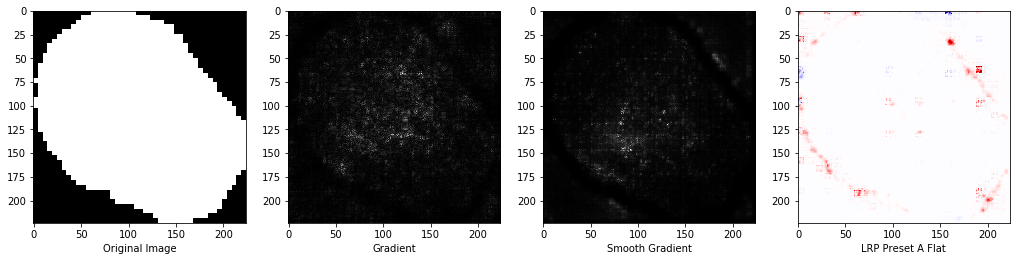

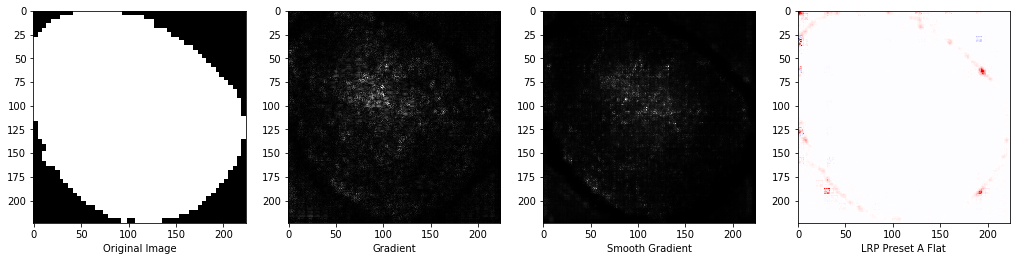

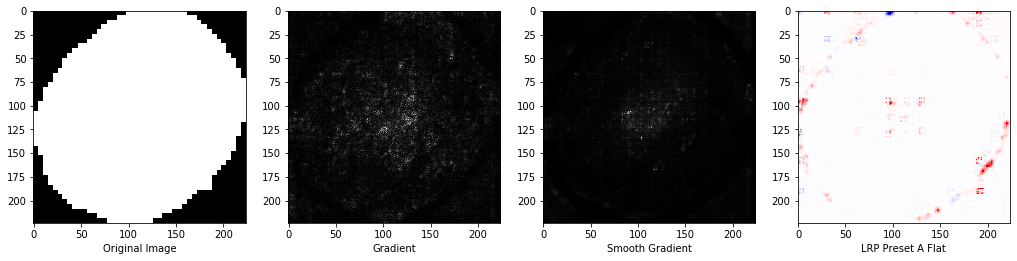

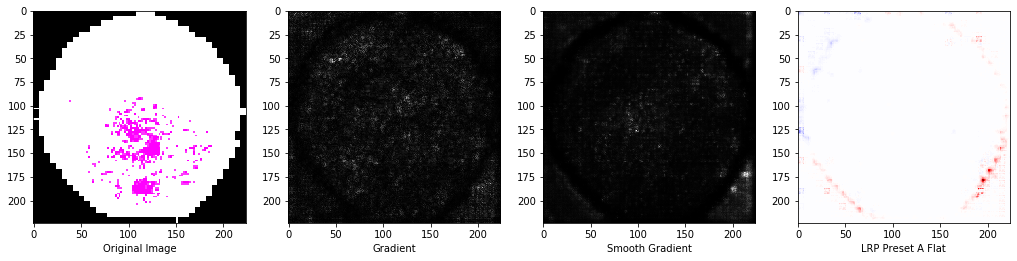

In [34]:
for image_index in sample_indices:
  show_explanation(tn[:,image_index,:,:,:],analyzers,analyzer_names,methods)

Similar to the baseline model, the finetuned resnet50 model 'checks' the boundary to predict the case of 'Unparasitized'.

### False Positive

In [43]:
# 4 random false positive samples
sample_indices = [np.random.choice(len(fp[0])) for i in range(4)]
print('The sample indices for false positives are {}'.format(sample_indices))

The sample indices for false positives are [26, 13, 7, 14]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


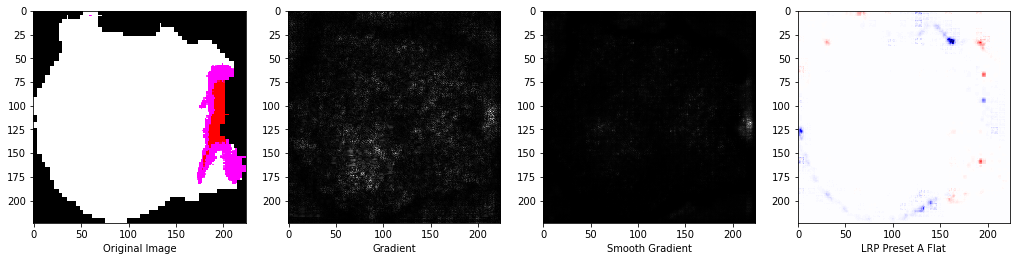

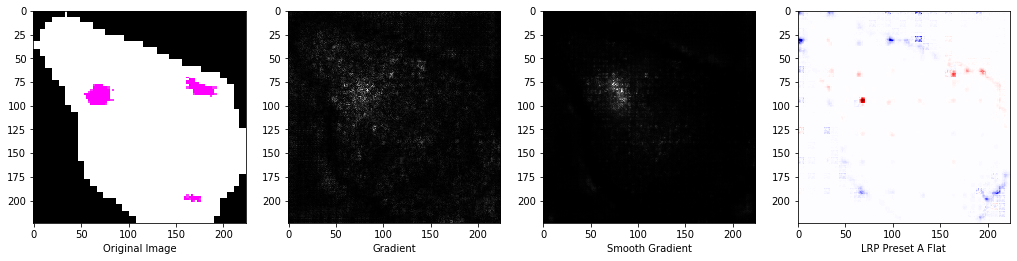

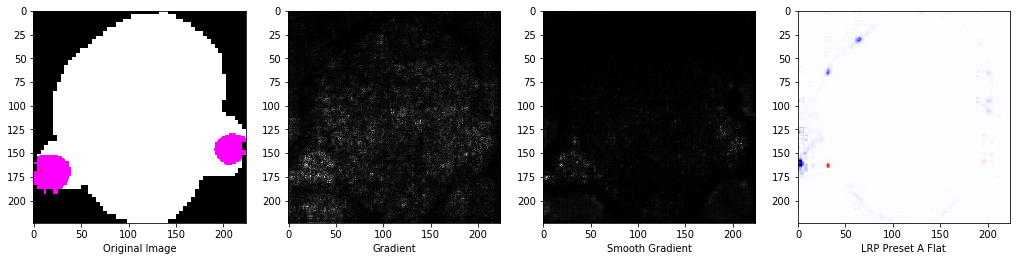

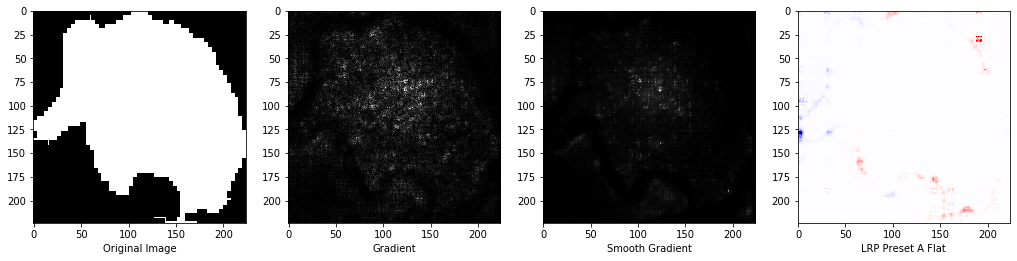

In [44]:
for image_index in sample_indices:
  show_explanation(fp[:,image_index,:,:,:],analyzers,analyzer_names,methods)

For the false positives, the model seems to be similarly confused by parts that might look indicative of 'Parasitized' from a human perspective ( Pink regions in the preprocessed images ). It would have been more confident of being correct ('Unparasitized') by checking the boundaries.

### False Negatives

In [45]:
# 4 random false negative samples
sample_indices = [np.random.choice(len(fn[0])) for i in range(4)]
print('The sample indices for false negatives are {}'.format(sample_indices))


The sample indices for false negatives are [50, 0, 59, 73]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


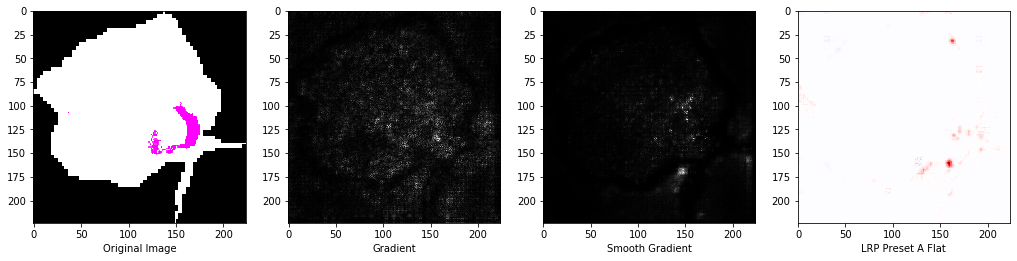

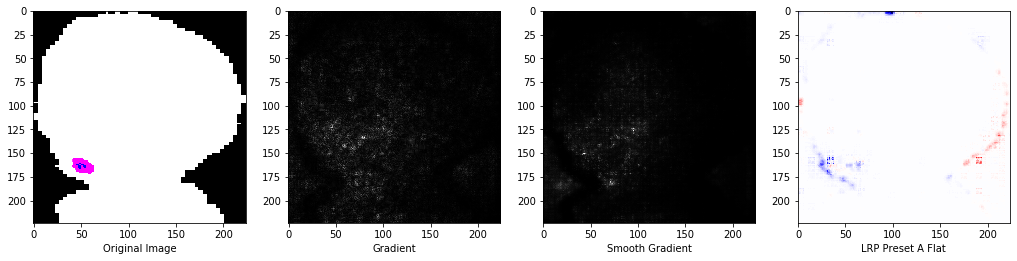

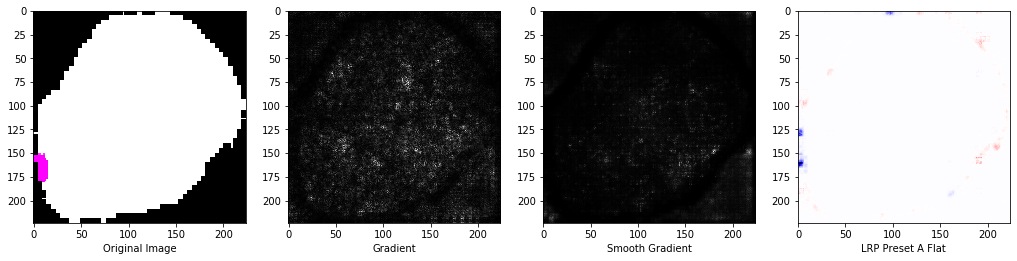

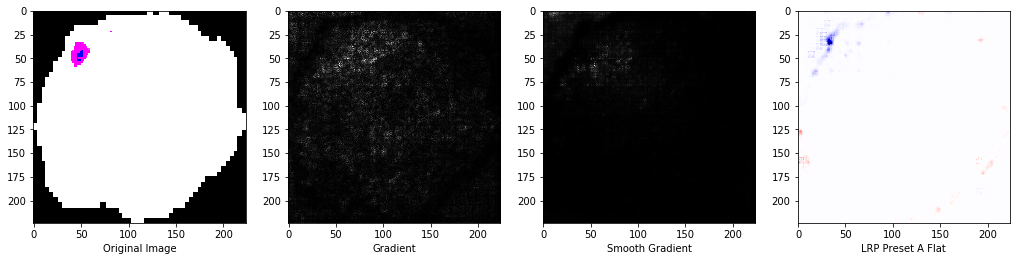

In [46]:
for image_index in sample_indices:
  show_explanation(fn[:,image_index,:,:,:],analyzers,analyzer_names,methods)

Because of the boundaries, the model is predicting 'Unparasitized' when it should be otherwise. A point of optimism here is that it is somehow certain towards the correct prediction by looking at the right parts. (Blue points of the LRP Preset A Flat map)